# **Installing Orion Library**

In [ ]:
# install dependencies then restart kernel and run again
! pip install orion-ml
! pip install 'urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1'

! git clone https://github.com/signals-dev/Orion.git
#moving all the required modules in current working directory
! mv Orion/notebooks/tulog/* .

# **Importing required libraries**

In [ ]:
# general imports 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#importing sklearn module
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
#utils.py contains all the plot function.
from utils import plot, plot_ts, plot_rws, plot_error, unroll_ts

# **Importing the dataset**

In [ ]:
#importing data module to load the dataset
from orion.data import load_signal, load_anomalies
#Import nyc_taxi dataset
signal = 'nyc_taxi'
# load_signal function load the given dataset
df = load_signal(signal)
# Since this dataset is already labelled, we will use load_anomalies functions to get all the known anomalies.
known_anomalies = load_anomalies(signal)
df.head(5)

,timestamp,value
0,1404165600,10844.0
1,1404167400,8127.0
2,1404169200,6210.0
3,1404171000,4656.0
4,1404172800,3820.0


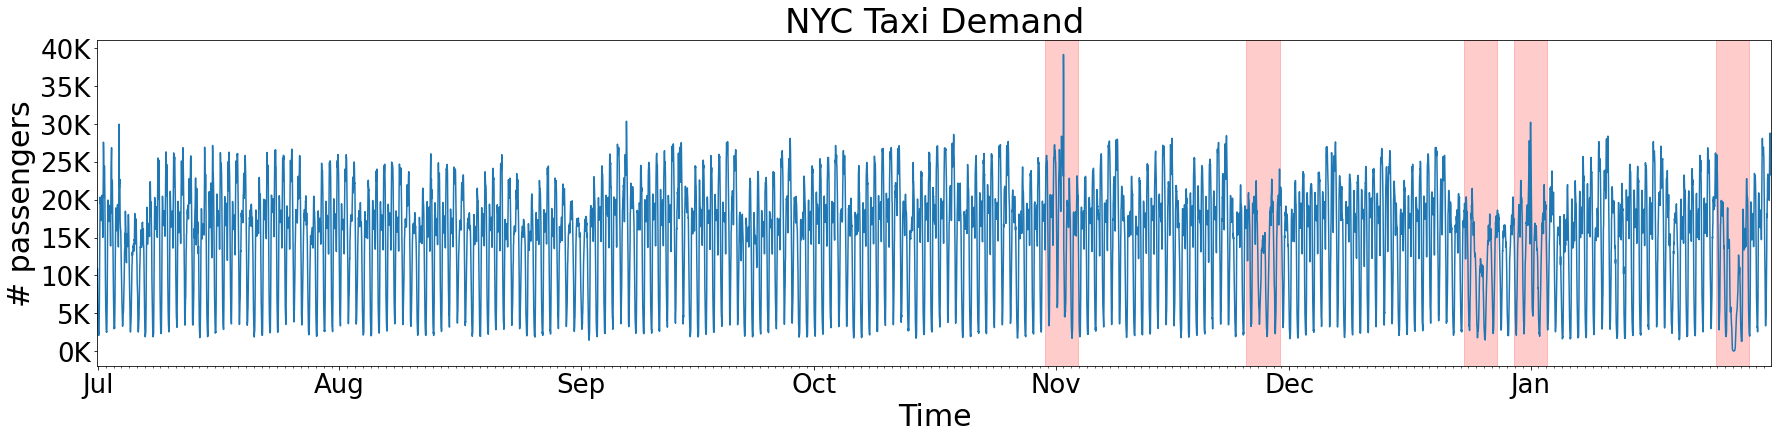

In [ ]:
#the pink-colored patch represent known anomaly
plot(df, known_anomalies)

# **ORION API**

In [ ]:
#importing Orion pipeline
from orion import Orion
#loading the TadGAN pipeline
orion = Orion(
    pipeline='tadgan.json')
#fitting the data to the TadGAN pipeline of Orion and detecting the outliers.
anomalies = orion.fit_detect(df)

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 1/35, [Dx loss: [-0.59541106 -3.075932    1.6398911   0.08406299]] [Dz loss: [-1.2336287  -1.017436   -1.595006    0.13788131]] [G loss: [ 2.582269   -1.625718    2.6830165   0.15249702]]
Epoch: 2/35, [Dx loss: [-0.8559294  -4.8606787   3.844098    0.01606509]] [Dz loss: [-2.946266   -1.3598921  -2.9176216   0.13312481]] [G loss: [ 1.2777017  -3.7755878   3.7491531   0.13041359]]
Epoch: 3/35, [Dx loss: [-0.68579614 -6.6879783   5.8272614   0.01749183]] [Dz loss: [-1.1593944  -0.9435781  -0.71613383  0.0500318 ]] [G loss: [-3.703592   -5.751043    0.971354    0.10760974]]
Epoch: 4/35, [Dx loss: [-0.23448518 -3.8546584   3.4953492   0.0124826 ]] [Dz loss: [-0.7361957  -0.69539124 -0.43019035  0.03893862]] [G loss: [-1.2584416  -2.799543    0.66492873  0.08761742]]
Epoch: 5/35, [Dx loss: [ -0.40891507  14.66807    -15.322829     0.02458428]] [Dz loss: [-1.1975706  -0.5163482  -1.090727    0.04095046]] [G loss: [17.748953   15.362417    1.4013526   0.09851819]]
Epoch: 6/35, [Dx loss

# **Visualize the output**

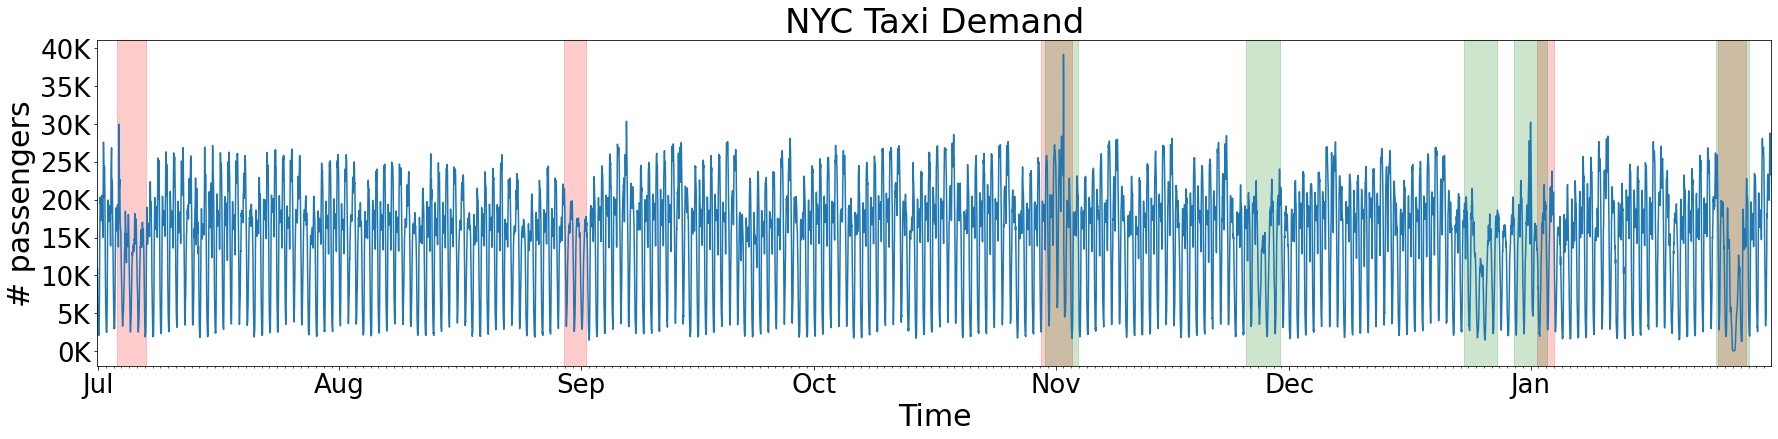

,start,end,severity
0,1404387000,1404703800,0.537583
1,1409340600,1409589000,0.294105
2,1414639800,1414981800,0.185099
3,1420137000,1420333200,0.088171
4,1422153000,1422464400,0.168966


In [ ]:
plot(df, [anomalies, known_anomalies])
anomalies.head(5)

# **Tracing Back to the functioning Model**

### **Primitives**

In [ ]:
import json
with open("/content/tadgan.json") as f:
  primitives = json.load(f)["primitives"]
print(primitives) 

['mlprimitives.custom.timeseries_preprocessing.time_segments_aggregate', 'sklearn.impute.SimpleImputer', 'sklearn.preprocessing.MinMaxScaler', 'mlprimitives.custom.timeseries_preprocessing.rolling_window_sequences', 'orion.primitives.tadgan.TadGAN', 'orion.primitives.tadgan.score_anomalies', 'orion.primitives.timeseries_anomalies.find_anomalies']


## **Data Preparation**

### **1. Data Frequency**

In [ ]:
def time_segments_aggregate(X, interval, time_column, method=['mean']):
    """Aggregate values over given time span.
    Args:
        X (ndarray or pandas.DataFrame):
            N-dimensional sequence of values.
        interval (int):
            Integer denoting time span to compute aggregation of.
        time_column (int):
            Column of X that contains time values.
        method (str or list):
            Optional. String describing aggregation method or list of strings describing multiple
            aggregation methods. If not given, `mean` is used.
    Returns:
        ndarray, ndarray:
            * Sequence of aggregated values, one column for each aggregation method.
            * Sequence of index values (first index of each aggregated segment).
    """
    #checking for the input datatype as numpy array and converting it to dataframe
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)
    #sorting the values on timestamp column and setting it as a index
    X = X.sort_values(time_column).set_index(time_column)

    if isinstance(method, str):
        method = [method]

    start_ts = X.index.values[0]
    max_ts = X.index.values[-1]

    values = list()
    index = list()
    while start_ts <= max_ts:
        end_ts = start_ts + interval
        subset = X.loc[start_ts:end_ts - 1]
        aggregated = [
            getattr(subset, agg)(skipna=True).values
            for agg in method
        ]
        values.append(np.concatenate(aggregated))
        index.append(start_ts)
        start_ts = end_ts

    return np.asarray(values), np.asarray(index)
#here df is the given dataframe and "timestamp" is the required column to be altered.
X, index = time_segments_aggregate(df, interval=1800, time_column='timestamp')

### **2. Data Imputation**

In [ ]:
#Using the simple scikit imputer
imp = SimpleImputer()
X = imp.fit_transform(X)

### **3. Data Normalization**

In [ ]:
#Normalizing the data using scikit-learn MinMaxScalar
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

### **4. Data Slicing**

In [ ]:
def rolling_window_sequences(X, index, window_size, target_size, step_size, target_column,
                             drop=None, drop_windows=False):
    """Create rolling window sequences out of time series data.
    The function creates an array of input sequences and an array of target sequences by rolling
    over the input sequence with a specified window.
    Optionally, certain values can be dropped from the sequences.
    Args:
        X (ndarray):
            N-dimensional sequence to iterate over.
        index (ndarray):
            Array containing the index values of X.
        window_size (int):
            Length of the input sequences.
        target_size (int):
            Length of the target sequences.
        step_size (int):
            Indicating the number of steps to move the window forward each round.
        target_column (int):
            Indicating which column of X is the target.
        drop (ndarray or None or str or float or bool):
            Optional. Array of boolean values indicating which values of X are invalid, or value
            indicating which value should be dropped. If not given, `None` is used.
        drop_windows (bool):
            Optional. Indicates whether the dropping functionality should be enabled. If not
            given, `False` is used.
    Returns:
        ndarray, ndarray, ndarray, ndarray:
            * input sequences.
            * target sequences.
            * first index value of each input sequence.
            * first index value of each target sequence.
    """
    out_X = list()
    out_y = list()
    X_index = list()
    y_index = list()
    target = X[:, target_column]

    if drop_windows:
        if hasattr(drop, '__len__') and (not isinstance(drop, str)):
            if len(drop) != len(X):
                raise Exception('Arrays `drop` and `X` must be of the same length.')
        else:
            if isinstance(drop, float) and np.isnan(drop):
                drop = np.isnan(X)
            else:
                drop = X == drop

    start = 0
    max_start = len(X) - window_size - target_size + 1
    while start < max_start:
        end = start + window_size

        if drop_windows:
            drop_window = drop[start:end + target_size]
            to_drop = np.where(drop_window)[0]
            if to_drop.size:
                start += to_drop[-1] + 1
                continue

        out_X.append(X[start:end])
        out_y.append(target[end:end + target_size])
        X_index.append(index[start])
        y_index.append(index[end])
        start = start + step_size

    return np.asarray(out_X), np.asarray(out_y), np.asarray(X_index), np.asarray(y_index)
#the target value; the value at time t.
#previous observed values, this is determined by the window width.
X, y, X_index, y_index = rolling_window_sequences(X, index, 
                                                  window_size=100, 
                                                  target_size=1, 
                                                  step_size=1,
                                                  target_column=0)

In [ ]:
print("Training data input shape: {}".format(X.shape))
print("Training data index shape: {}".format(X_index.shape))
print("Training y shape: {}".format(y.shape))
print("Training y index shape: {}".format(y_index.shape))

Training data input shape: (10222, 100, 1)
Training data index shape: (10222,)
Training y shape: (10222, 1)
Training y index shape: (10222,)


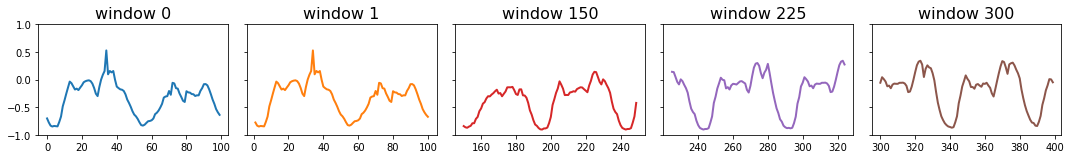

In [ ]:
#function from utils.py module. Representing all the windows that has been created by slicing
#Here X represents the input used to train the model. In the previous example, we see X has 10222 training data points.
#Notice that 100 represents the window size. On the other hand, y is the real signal after processing, 
#which we will use later on to calculate the error between the reconstructed and real signal.
plot_rws(X)

## **Training and Detection**

In [ ]:
from model import hyperparameters
from orion.primitives.tadgan import TadGAN

hyperparameters["epochs"] = 35
hyperparameters["shape"] = (100, 1) # based on the window size
hyperparameters["optimizer"] = "keras.optimizers.Adam"
hyperparameters["learning_rate"] = 0.0005
hyperparameters["latent_dim"] = 20
hyperparameters["batch_size"] = 64

tgan = TadGAN(**hyperparameters)
tgan.fit(X)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected

Epoch: 1/35, [Dx loss: [-0.7957401 -6.6152525  5.1290245  0.0690488]] [Dz loss: [-1.254875   -1.2086544  -1.3448243   0.12986039]] [G loss: [-1.7152898  -5.109496    2.0687068   0.13254997]]
Epoch: 2/35, [Dx loss: [-0.5342036  -6.771801    6.10927     0.01283287]] [Dz loss: [-2.5000403 -1.7069153 -1.7072576  0.0914132]] [G loss: [-2.622784   -6.10575     2.2840433   0.11989234]]
Epoch: 3/35, [Dx loss: [ -0.5339819  -10.839651    10.167579     0.01380888]] [Dz loss: [-1.485765   -1.167771   -0.7707543   0.04527596]] [G loss: [ -8.204354  -10.196201    1.2471316   0.0744715]]
Epoch: 4/35, [Dx loss: [-0.30425572 -8.709031    8.278672    0.01261049]] [Dz loss: [-0.6987138  -0.02213453 -1.1440139   0.04674349]] [G loss: [-5.6577926  -8.241503    1.8101897   0.07735204]]
Epoch: 5/35, [Dx loss: [-5.3286654e-01 -1.1660512e+01  1.1017098e+01  1.1054636e-02]] [Dz loss: [-0.78868043  2.7140272  -4.2994237   0.07967175]] [G loss: [ -5.030117   -10.875936     5.1045227    0.07412934]]
Epoch: 6/35, 

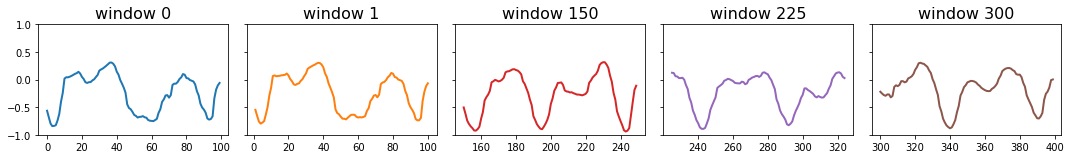

In [ ]:
# reconstructing the signal
X_hat, critic = tgan.predict(X)
# visualize X_hat
plot_rws(X_hat)

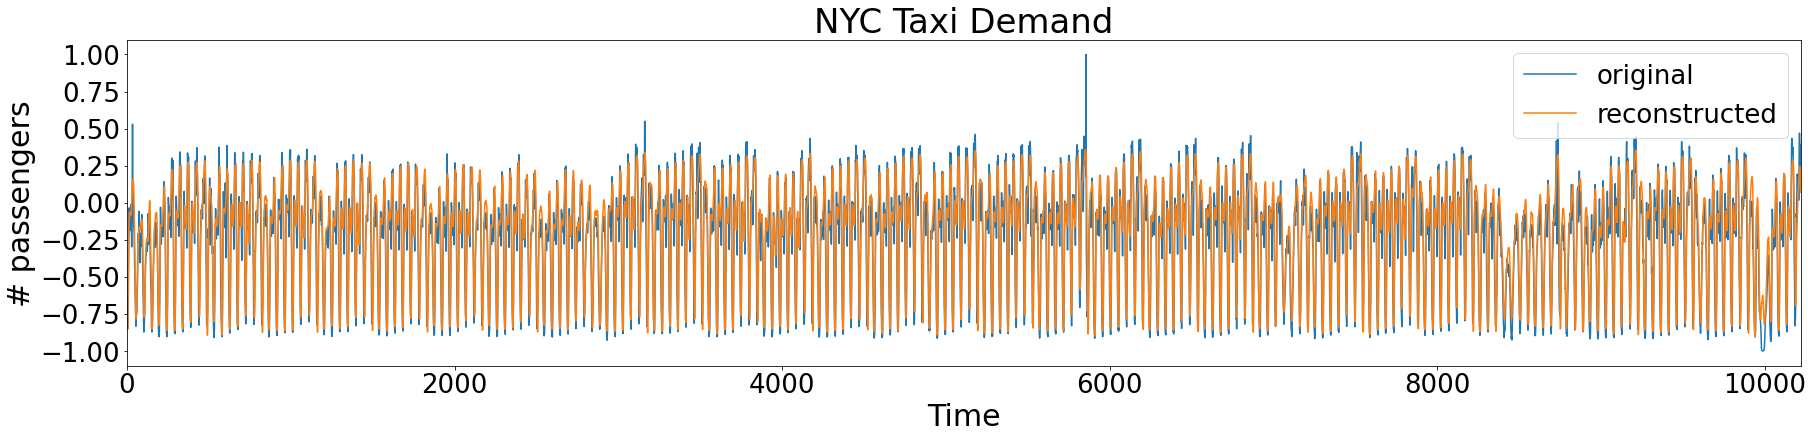

In [ ]:
# flatten the predicted windows 
y_hat = unroll_ts(X_hat)
# plot the time series data 
plot_ts([y, y_hat], labels=['original', 'reconstructed'])

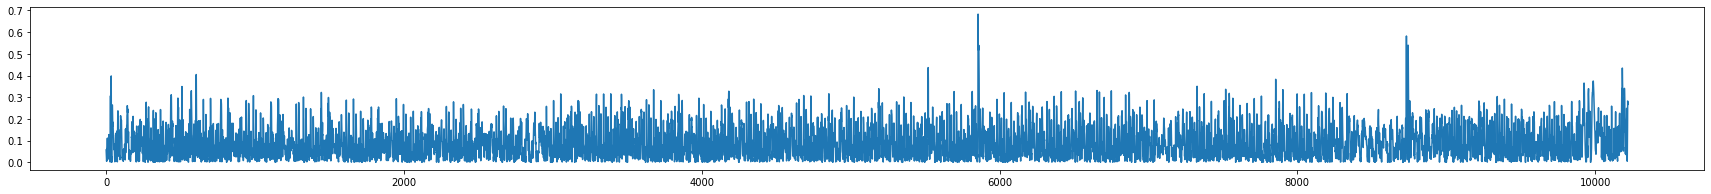

In [ ]:
# pair-wise error calculation
error = np.zeros(shape=y.shape)
length = y.shape[0]
for i in range(length):
    error[i] = abs(y_hat[i] - y[i])

# visualize the error curve
fig = plt.figure(figsize=(30, 3))
plt.plot(error)
plt.show()

## **Error Computation**

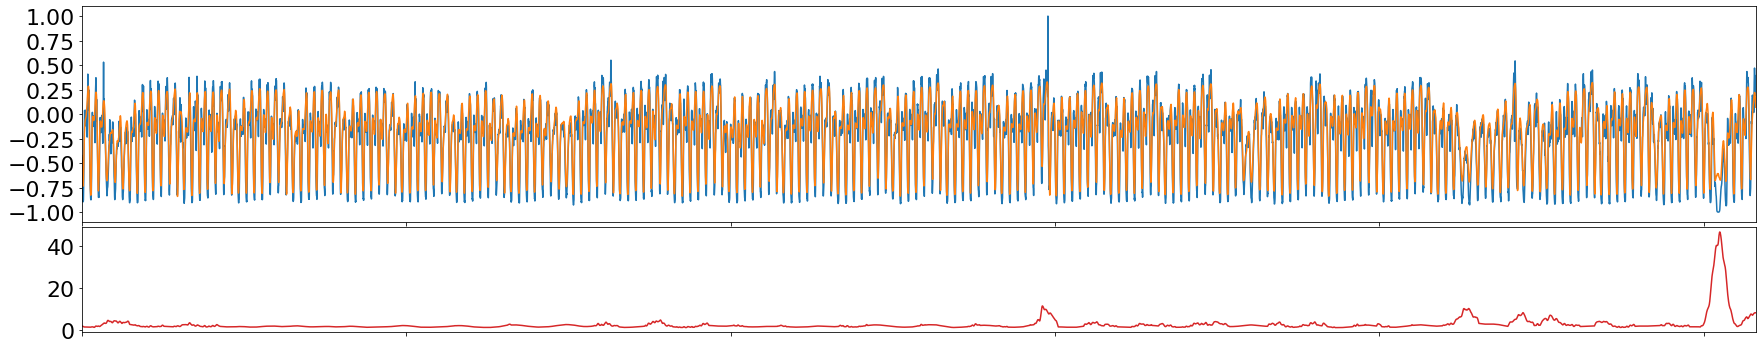

In [ ]:
from orion.primitives.tadgan import score_anomalies
error, true_index, true, pred = score_anomalies(X, X_hat, critic, X_index, rec_error_type="dtw", comb="mult")
pred = np.array(pred).mean(axis=2)
# visualize the error curve
plot_error([[true, pred], error])

In [ ]:
# threshold to classify the high peak data points as anomolous points
thresh = 10

intervals = list()

i = 0
max_start = len(error)
while i < max_start:
    j = i
    start = index[i]
    while error[i] > thresh:
        i += 1
    
    end = index[i]
    if start != end:
        intervals.append((start, end, np.mean(error[j: i+1])))
        
    i += 1
        
intervals

[(1414816200, 1414843200, 10.835606175180914),
 (1419498000, 1419510600, 10.086319740811176),
 (1419550200, 1419562800, 10.11538595438212),
 (1422208800, 1422460800, 28.858012419781314)]

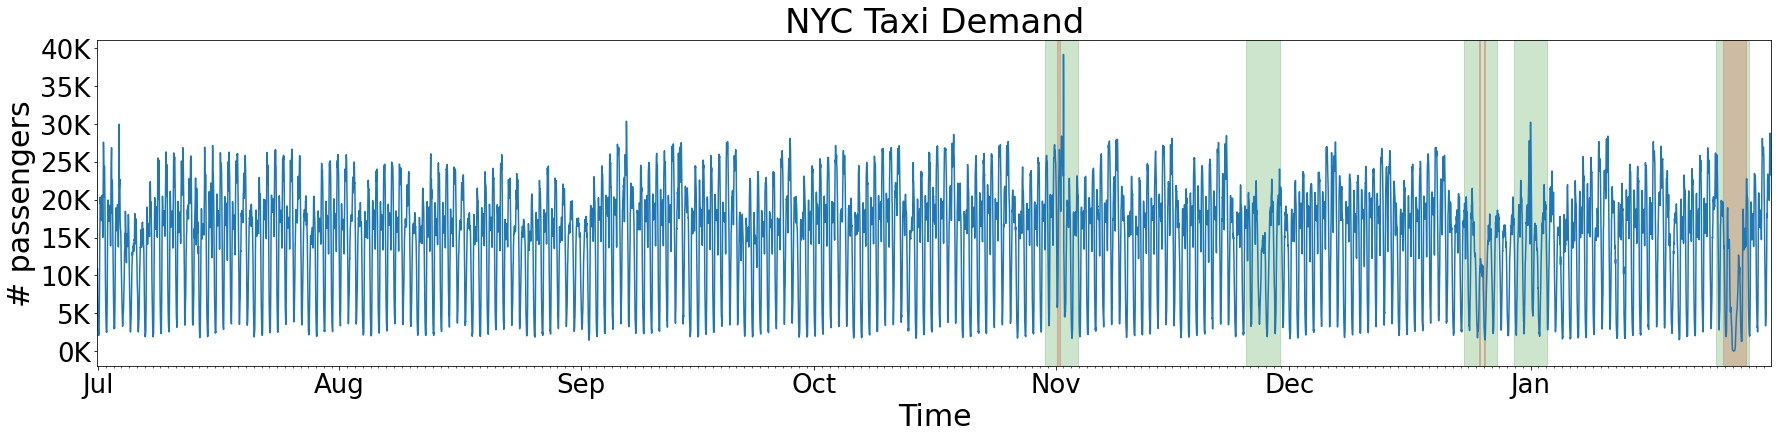

In [ ]:
anomalies = pd.DataFrame(intervals, columns=['start', 'end', 'score'])
#now plotting the actual data, known anomalies and predicted anomalies
plot(df, [anomalies, known_anomalies])

In [ ]:
from orion.primitives.timeseries_anomalies import find_anomalies
# find anomalies
intervals = find_anomalies(error, index, 
                           window_size_portion=0.33, 
                           window_step_size_portion=0.1, 
                           fixed_threshold=True)
intervals

array([[1.40435820e+09, 1.40476860e+09, 1.66752101e-01],
       [1.41040800e+09, 1.41068880e+09, 3.83570228e-01],
       [1.41471720e+09, 1.41502140e+09, 1.16777833e+00],
       [1.41939540e+09, 1.41966540e+09, 3.03157333e-01],
       [1.42217280e+09, 1.42249860e+09, 1.89817526e+00]])

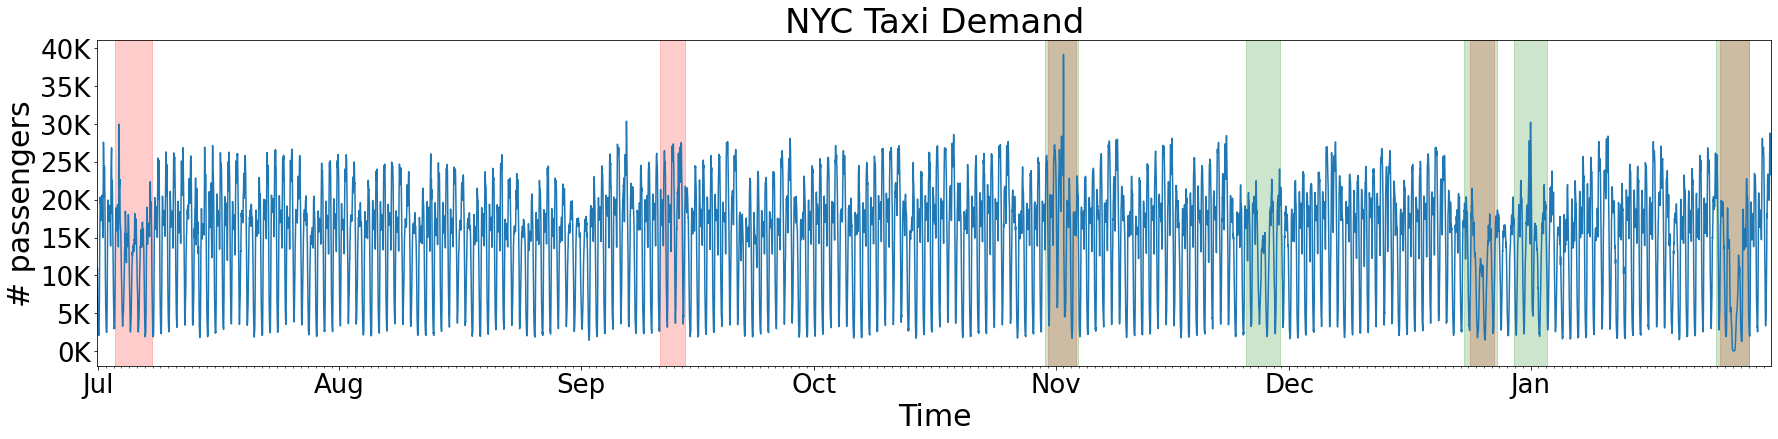

In [ ]:
# visualize the result
anomalies = pd.DataFrame(intervals, columns=['start', 'end', 'score'])
plot(df, [anomalies, known_anomalies])

# **End-to-End Pipeline Configuration**

In [ ]:
from orion import Orion
#paramter dictionary contains the parameter which are to be overridden.
parameters = {
    "mlprimitives.custom.timeseries_preprocessing.time_segments_aggregate#1": {
            "interval": 3600 # hour level
        },
    'orion.primitives.tadgan.TadGAN#1': {
        'epochs': 15,
        }
}

orion = Orion(
    'tadgan.json',
    parameters
)

anomalies = orion.fit_detect(df)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected

Epoch: 1/15, [Dx loss: [-0.8384325  -2.9288373   0.8207574   0.12696473]] [Dz loss: [-1.5578253  -2.2607028  -0.9175762   0.16204537]] [G loss: [ 2.9712832  -0.78141814  1.8121263   0.1940575 ]]
Epoch: 2/15, [Dx loss: [-2.429922   -4.1689634   1.5162655   0.02227774]] [Dz loss: [-0.72279733 -2.398735    0.92349803  0.075244  ]] [G loss: [-0.52864873 -1.4926456  -0.6757791   0.1639776 ]]
Epoch: 3/15, [Dx loss: [-1.6316088  -4.1243773   2.3043537   0.01884155]] [Dz loss: [-2.3128848 -2.447866  -0.8801529  0.1015135]] [G loss: [ 0.61383337 -2.2535279   1.3306092   0.15367518]]
Epoch: 4/15, [Dx loss: [-1.5165364  -3.5654135   1.8562028   0.01926738]] [Dz loss: [-2.0728009  -1.3208715  -1.5982127   0.08462835]] [G loss: [ 1.8594401  -1.8583027   2.2308502   0.14868927]]
Epoch: 5/15, [Dx loss: [-1.3474088  -3.0841682   1.5478653   0.01888945]] [Dz loss: [-1.6703793 -0.8698271 -1.2894241  0.0488872]] [G loss: [ 1.2469118  -1.481832    1.6500028   0.10787412]]
Epoch: 6/15, [Dx loss: [-0.805212

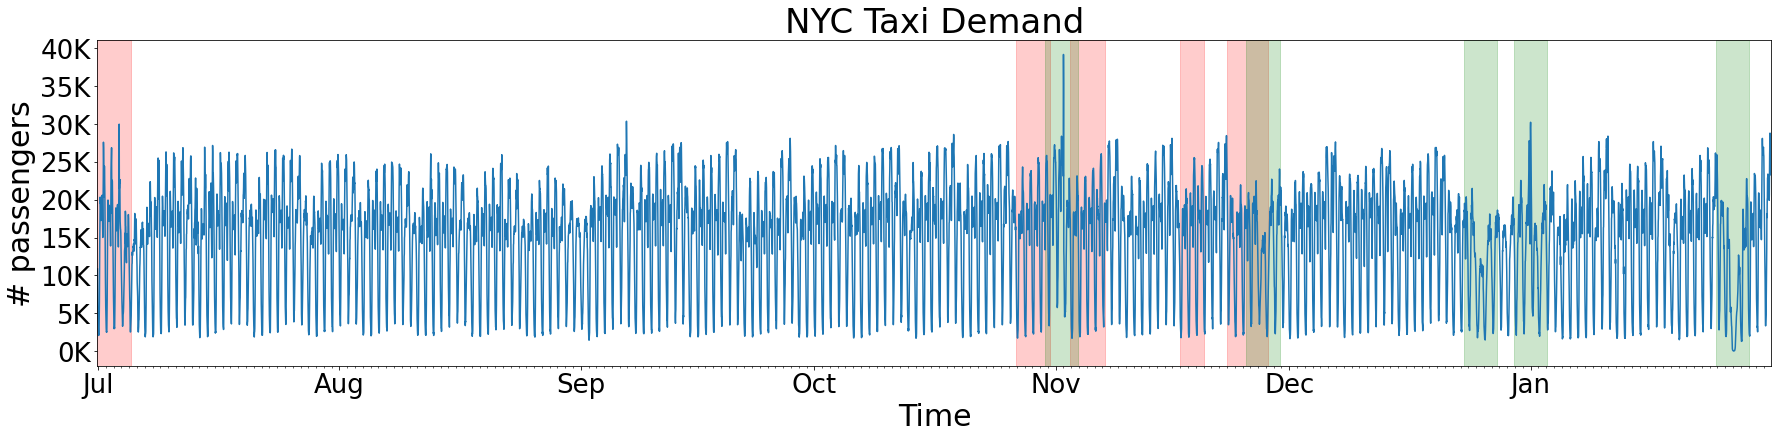

In [ ]:
#Plotting the anomalies
plot(df, [anomalies, known_anomalies])

# **Evaluation Methods**

## **Dummy Dataset**

In [ ]:
#Let's assume that the signal starts at timestamp 1, and ends at timestamp 20. 
#We can then see that the ground truth contains three anomalies, namely (5, 8), (12, 13), and (17, 18),
#where (i, j) expresses the starting timestamp i and ending timestamp j.
#We can also see that, we detected two anomalies, namely (5, 8) and (12, 15). So how can we compare both sets?
import numpy as np
# to reproduce the same dummy signal
np.random.seed(0)
# dummy data
start, end = (1, 20)
signal = np.random.rand(end - start, 1)
ground_truth = [
    (5, 8),
    (12, 13),
    (17, 18)
]
anomalies = [
    (5, 8),
    (12, 15)
]

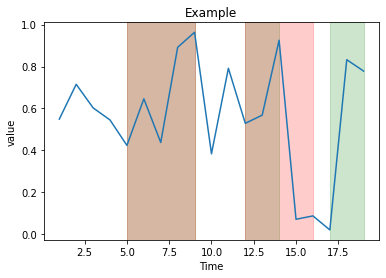

In [ ]:
#plotting the dummy dataset with the anomaly
import matplotlib.pyplot as plt

time = range(start, end)
plt.plot(time, signal)

# ground truth
for i, (t1, t2) in enumerate(ground_truth):
    plt.axvspan(t1, t2+1, color="g", alpha=0.2, label="ground_truth")

# detected
for i, (t1, t2) in enumerate(anomalies):
    plt.axvspan(t1, t2+1, color="r", alpha=0.2, label="detected")

    
plt.title("Example")
plt.xlabel("Time")
plt.ylabel("value")
plt.show()

### **Evaluation of dummy dataset through weighted segment**

In [ ]:
#we can use orion.evaluation subpackage to compute multiple metrics using the weighted segment approach. 
#For example to compute the accuracy, we use contextual_accuracy(..., weighted=True). 
#There are other metrics available, for reference checkout the orion.evaluation documentation.
from orion.evaluation.contextual import contextual_accuracy, contextual_f1_score
accuracy = contextual_accuracy(ground_truth, anomalies, start=start, end=end)
f1_score = contextual_f1_score(ground_truth, anomalies, start=start, end=end)
print("Accuracy score = {:0.3f}".format(accuracy))
print("F1 score = {:0.3f}".format(f1_score))

Accuracy score = 0.789
F1 score = 0.750


### **Evaluation of dummy dataset through overlapping segment**

In [ ]:
#Similarly, we can use the same metric functions, but with parameter weighted=False. 
#Note: overlap segment approach, does not account for true negatives. 
#Reason being, anomalies in time series data are rare and so "normal" instances will skew the value of the computed metric. 
#Therefore, using this approach we cannot compute metrics such as the accuracy. 
f1_score = contextual_f1_score(ground_truth, anomalies, start=start, end=end, weighted=False)
print("F1 score = {:0.3f}".format(f1_score))

F1 score = 0.800


## **Pipelin Evaluation End-to-End**

In [ ]:
from orion import Orion
from orion.data import load_signal, load_anomalies
#Importing all the methods for evaluation
from orion.evaluation.contextual import contextual_accuracy, contextual_f1_score, contextual_precision
metrics = [
    'f1',
    'recall',
    'precision',
]
orion = Orion(
    'tadgan.json'
)
signal = 'nyc_taxi'
# load signal
df = load_signal(signal)
# load ground truth anomalies
ground_truth = load_anomalies(signal)
#Evaluation scores mentioned in the metrics list
scores = orion.evaluate(df, ground_truth, fit=True, metrics=metrics)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected

Epoch: 1/35, [Dx loss: [-0.7446103 -3.38354    1.916412   0.0722518]] [Dz loss: [-0.8709331  -1.588682   -0.39208835  0.11098377]] [G loss: [ 1.0742891  -1.8552703   1.1434454   0.17861143]]
Epoch: 2/35, [Dx loss: [-0.66076994 -4.2382727   3.4087803   0.01687243]] [Dz loss: [-2.2585924  -1.972591   -1.1722355   0.08862338]] [G loss: [-0.5743303  -3.3342292   1.5360025   0.12238964]]
Epoch: 3/35, [Dx loss: [-0.43095383 -3.2599273   2.6969135   0.01320591]] [Dz loss: [-1.2770281  -1.1511683  -0.76164323  0.06357831]] [G loss: [-0.5214179  -2.7614346   1.3028992   0.09371176]]
Epoch: 4/35, [Dx loss: [-0.5274176  -8.311386    7.6677146   0.01162515]] [Dz loss: [-1.2697105  -0.48698938 -1.1577789   0.03750571]] [G loss: [-4.980394   -7.4895387   1.687638    0.08215055]]
Epoch: 5/35, [Dx loss: [-0.55211776 -3.4503748   2.7874832   0.01107748]] [Dz loss: [-1.7409471   2.1248145  -5.236253    0.13704924]] [G loss: [ 5.5313087  -2.6707125   7.0234303   0.11785912]]
Epoch: 6/35, [Dx loss: [-0.47

In [ ]:
scores

f1           0.535804
recall       0.519418
precision    0.553258
dtype: float64